# Street Fighter Tutorial
This notebook accompanies the YouTube tutorial on <a href='https://www.youtube.com/c/NicholasRenotte'>Nicholas Renotte</a>

## Need to install
!pip install opencv-python

!pip install stable-baselines3[extra] optuna

# Setup StreetFighter

In [111]:
model_name = "PPO-delta"
checkpoints = 100000
model_checkpoints = "best_model_" + str(checkpoints) # Speicify the model file to load. Model "ppo_ryu_2500000_steps_updated" is capable of beating the final stage (Bison) of the game.


RENDERING = True    # Whether to render the game screen.
RESET_ROUND = True  # Whether to reset the round when fight is over. 

RANDOM_ACTION = False
NUM_EPISODES = 100 # Make sure NUM_EPISODES >= 3 if you set RESET_ROUND to False to see the whole final stage game.
MODEL_DIR = "trained_models_" + model_name +"/"


In [112]:
from pyvirtualdisplay import Display

if RENDERING:
    virtual_display = Display(visible=0, size=(1400, 900))
    virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

# Setup Environment
## What we are going to do! FUNNN
- Observation Preprocess - grayscale (DONE), frame delta, resize the frame so we have less pixels  (DONE) 
- Filter the action - parameter DONE
- Reward function - set this to the score

In [113]:
# Import retro to play Street Fighter using a ROM
import retro

import math
import time

import gym
import numpy as np

# Import opencv for grayscaling
import cv2

# Import the space shapes for the environment
from gym.spaces import Box

# Custom environment wrapper
class StreetFighterCustomWrapper(gym.Wrapper):
    def __init__(self, env, reset_round=True, rendering=False):
        super(StreetFighterCustomWrapper, self).__init__(env)
        self.env = env

        # Specify action space and observation space 
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        # self.action_space = MultiBinary(12)
        # # Startup and instance of the game 
        # self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', 
        #                        state="Champion.Level12.RyuVsBison", 
        #                        use_restricted_actions=retro.Actions.FILTERED)
    
    def reset(self):
        # Return the first frame 
        obs = self.env.reset()
        obs = self.preprocess(obs) 
        self.previous_frame = obs 
        
        # Create a attribute to hold the score delta 
        self.score = 0 
        return obs
    
    def preprocess(self, observation): 
        # Grayscaling 
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        # Resize 
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        # Add the channels value
        channels = np.reshape(resize, (84,84,1))
        return channels 

    def step(self, action):
        # Take a step 
        obs, reward, done, info = self.env.step(action)
        obs = self.preprocess(obs) 
        
        # Frame delta 
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs 
        
        # Reshape the reward function
        reward = info['score'] - self.score 
        self.score = info['score'] 
        
        return frame_delta, reward, done, info
    

In [ ]:
env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis',
                state="Champion.Level12.RyuVsBison", 
                use_restricted_actions=retro.Actions.FILTERED)
env = StreetFighterCustomWrapper(env)
# env = Monitor(env)

In [ ]:
# Reset game to starting state
obs = env.reset()

# Set flag to flase
done = False

if RENDERING:
    print(type(env.render(mode='rgb_array')))
    img = plt.imshow(env.render(mode='rgb_array'))

for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        # env.render()
        
        obs, reward, done, info = env.step(env.action_space.sample())

        if RENDERING:
            img.set_data(env.render(mode='rgb_array'))
            display.display(plt.gcf())
            display.clear_output(wait=True)
        
        time.sleep(0.01)
        # print(reward)

In [ ]:
obs = env.reset()

In [ ]:
obs, reward, done, info = env.step(env.action_space.sample())

In [ ]:
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

In [115]:
env.close()

# Hyperparameter tune

In [ ]:
!pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [96]:
# Importing the optimzation frame - HPO
import optuna
# PPO algo for RL
from stable_baselines3 import PPO
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
# Import the sb3 monitor for logging 
from stable_baselines3.common.monitor import Monitor
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with filepaths
import os
import sys

In [85]:
LOG_DIR = './logs/'
# OPT_DIR = './opt/'
OPT_DIR = "opt_" + model_name

In [78]:
# Function to return test hyperparameters - define the object function
def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 2048, 8192),
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99)
    }

In [79]:
SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

In [81]:
# Run a training loop and return mean reward 
def optimize_agent(trial):
    try:
        model_params = optimize_ppo(trial) 

        # Create environment 
        # env = StreetFighter()
        env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis',
                            state="Champion.Level12.RyuVsBison", 
                            use_restricted_actions=retro.Actions.FILTERED)
        env = StreetFighterCustomWrapper(env)
        env = Monitor(env, LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Create algo 
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params)
        model.learn(total_timesteps=30000)
        #model.learn(total_timesteps=100000)

        # Evaluate model 
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    except Exception as e:
        return -1000

In [82]:
# Creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=10, n_jobs=1)
#study.optimize(optimize_agent, n_trials=100, n_jobs=1)

[I 2023-05-22 19:51:30,608] A new study created in memory with name: no-name-1d9177dc-898b-4f4b-b443-3582b151ffb1
/tmp/ipykernel_827931/3802630500.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
/tmp/ipykernel_827931/3802630500.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
/tmp/ipykernel_827931/3802630500.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_flo

In [83]:
study.best_params

'''
{'n_steps': 5542,
 'gamma': 0.841615894986323,
 'learning_rate': 2.4877289885597835e-05,
 'clip_range': 0.2622852669044159,
 'gae_lambda': 0.8517353230777983}
'''

{'n_steps': 5542,
 'gamma': 0.841615894986323,
 'learning_rate': 2.4877289885597835e-05,
 'clip_range': 0.2622852669044159,
 'gae_lambda': 0.8517353230777983}

In [84]:
study.best_trial

'''
FrozenTrial(number=6,...
'''

FrozenTrial(number=6, state=TrialState.COMPLETE, values=[1090911.0], datetime_start=datetime.datetime(2023, 5, 22, 20, 11, 18, 388698), datetime_complete=datetime.datetime(2023, 5, 22, 20, 14, 25, 614022), params={'n_steps': 5542, 'gamma': 0.841615894986323, 'learning_rate': 2.4877289885597835e-05, 'clip_range': 0.2622852669044159, 'gae_lambda': 0.8517353230777983}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_steps': IntDistribution(high=8192, log=False, low=2048, step=1), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'clip_range': FloatDistribution(high=0.4, log=False, low=0.1, step=None), 'gae_lambda': FloatDistribution(high=0.99, log=False, low=0.8, step=None)}, trial_id=6, value=None)

# Setup Callback

In [86]:
# Import base callback 
from stable_baselines3.common.callbacks import BaseCallback

In [87]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [88]:
MODEL_DIR = "trained_models_" + model_name

In [89]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=MODEL_DIR)

# Train Model

In [98]:
# Create environment 
# env = StreetFighter()
env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis',
                state="Champion.Level12.RyuVsBison", 
                use_restricted_actions=retro.Actions.FILTERED)
env = StreetFighterCustomWrapper(env)
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [99]:
model_params = study.best_params
model_params['n_steps'] = 5568  # set n_steps to a factor of 64
# model_params['learning_rate'] = 5e-7
model_params

{'n_steps': 5568,
 'gamma': 0.841615894986323,
 'learning_rate': 2.4877289885597835e-05,
 'clip_range': 0.2622852669044159,
 'gae_lambda': 0.8517353230777983}

In [100]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **model_params)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [101]:
# Reload previous weights from HPO
model.load(os.path.join(OPT_DIR, 'trial_6_best_model.zip'))

In [102]:
original_stdout = sys.stdout
log_file_path = os.path.join(MODEL_DIR, "training_log.txt")
with open(log_file_path, 'w') as log_file:
    sys.stdout = log_file

    model.learn(total_timesteps=100000, callback=callback)
    # model.learn(total_timestep=5000000)
    
    env.close()

# Restore stdout
sys.stdout = original_stdout

# Evaluate the Model

In [103]:
model = PPO.load('./trained_models_PPO-delta/best_model_100000.zip')

In [ ]:
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)

In [ ]:
mean_reward

# Test out the Model

In [124]:
env.close()

In [121]:
import os
import time 

import retro
from stable_baselines3 import PPO

env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis',
                state="Champion.Level12.RyuVsBison", 
                use_restricted_actions=retro.Actions.FILTERED)
env = StreetFighterCustomWrapper(env)
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [122]:
env.observation_space.shape

(84, 84, 4)

KeyboardInterrupt: 

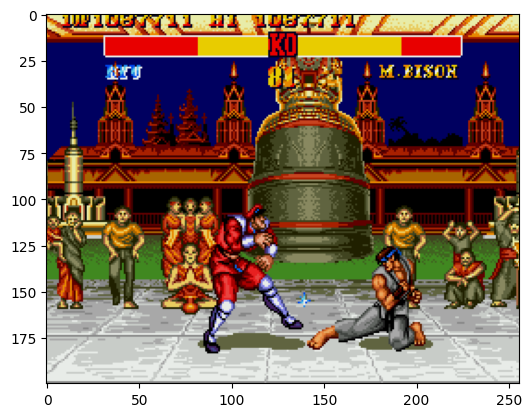

In [123]:

if not RANDOM_ACTION:
    model = PPO.load(os.path.join(MODEL_DIR, model_checkpoints))

obs = env.reset()
done = False

num_episodes = NUM_EPISODES
episode_reward_sum = 0
num_victory = 0

print("\nFighting Begins!\n")

for _ in range(num_episodes):
    done = False
    
    if RESET_ROUND:
        obs = env.reset()

    total_reward = 0

    if RENDERING:
        img = plt.imshow(env.render(mode='rgb_array'))

    while not done:
        timestamp = time.time()

        if RANDOM_ACTION:
            # sample action from action space
            # obs, reward, done, info = env.step(env.action_space.sample())

            # test specified action
            # button_combos [[0, 16, 32], [0, 64, 128], [0, 1, 2, 3, 256, 257, 512, 513, 1024, 1026, 1536, 2048, 2304, 2560]]
            # buttons ['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']
            test_action = [0,0,0,0,1,0,0,0,0,0,0,0]
            obs, reward, done, info = env.step(test_action)
        else:
            action, _states = model.predict(obs)
            # print(action)
            obs, reward, done, info = env.step(action)

        if reward != 0:
            total_reward += reward
            # print("Reward: {:.3f}, playerHP: {}, enemyHP:{}".format(reward, info['agent_hp'], info['enemy_hp']))
        
        # done should be returned by env.step() when the game is over
        # if info['enemy_hp'] < 0 or info['agent_hp'] < 0:
        #     done = True

        if RENDERING:
            img.set_data(env.render(mode='rgb_array'))
            display.display(plt.gcf())
            display.clear_output(wait=True)

    if info['enemy_hp'] < 0:
        print(_, "Victory!")
        num_victory += 1
    else:
        print(_, "Lose...")

    # print("Total reward: {}\n".format(total_reward))
    episode_reward_sum += total_reward

    if not RESET_ROUND:
        while info['enemy_hp'] < 0 or info['agent_hp'] < 0:
        # Inter scene transition. Do nothing.
            obs, reward, done, info = env.step([0] * 12)
            if RENDERING:
                env.render(mode='rgb_array')

env.close()

print("\nFighting Ends!\n")
print(model_checkpoints)
print("Winning rate: {}".format(1.0 * num_victory / num_episodes))
if RANDOM_ACTION:
    print("Average reward for random action: {}".format(episode_reward_sum/num_episodes))
else:
    print("Average reward for {}: {}".format(model_checkpoints, episode_reward_sum/num_episodes))